In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

# import the required libraries
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from tqdm 

# Facial Keypoint Recognition Training Notebook

In [3]:
os.listdir('data1')

['test',
 'test_frames_keypoints.csv',
 'training',
 'training_frames_keypoints.csv']

In [4]:
# Load Metadata
keypoints = pd.read_csv("data1/training_frames_keypoints.csv")

In [5]:
keypoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462 entries, 0 to 3461
Columns: 137 entries, Unnamed: 0 to 135
dtypes: float64(136), object(1)
memory usage: 3.6+ MB


In [6]:
# Show Sample of Data
keypoints.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [7]:
key_pts_frame = pd.read_csv('data1/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = np.array(key_pts_frame.iloc[n, 1:])
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [8]:
def show_keypoints(image_name, key_pts):
    img = cv2.imread("data1/training/{}".format(image_name), 0)
    """Show image with keypoints"""
    plt.imshow(img)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

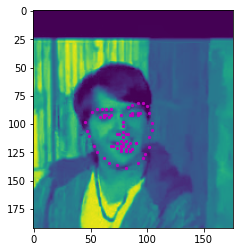

In [9]:
#Example Output 
show_keypoints(image_name, key_pts)

# Loading Data

In [28]:
# Loading Model

xtest = np.load("ModelData/xtest.npy")/255
xtrain = np.load("ModelData/xtrain.npy")/255
ytest = np.load("ModelData/ytest.npy").reshape(-1, 136)
ytrain = np.load("ModelData/ytrain.npy").reshape(-1, 136)

In [29]:
print("Testing Data: ",xtest.shape)
print("Training Data: ",xtrain.shape)
print("Testing Targets: ",ytest.shape)
print("Training Targets: ",ytrain.shape)

Testing Data:  (3337, 100, 100, 3)
Training Data:  (3337, 100, 100, 3)
Testing Targets:  (3337, 136)
Training Targets:  (3337, 136)


# Model Creation

Using a MobileNetV2 model as a base model.

In [30]:
input_shape = (100,100,3)
output_shape = (1,1,136)
# Base Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape= (96,96,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

# Freezing Layers

print(len(base_model.layers))
for layer in base_model.layers[:-20]:
    layer.trainable = False

154


In [31]:

inputs = tf.keras.Input(input_shape)

base_model_outputs = base_model(inputs)

x = tf.keras.layers.BatchNormalization()(base_model_outputs)
x = tf.keras.layers.Activation( 'relu' )(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

x = tf.keras.layers.SeparableConv2D( 150 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )(inputs)
x = tf.keras.layers.SeparableConv2D( 150 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' )(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

x = tf.keras.layers.SeparableConv2D( 136 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' )(x)
x = tf.keras.layers.SeparableConv2D( 136 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' )(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.SeparableConv2D( 136 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' )(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.SeparableConv2D( 136 , kernel_size=( 2 , 2 ) , strides=1 , activation='sigmoid')(x)
outputs = tf.keras.layers.GlobalMaxPooling2D()(x)

model = tf.keras.Model(inputs,outputs)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
separable_conv2d_12 (Separab (None, 98, 98, 150)       627       
_________________________________________________________________
separable_conv2d_13 (Separab (None, 97, 97, 150)       23250     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 150)       0         
_________________________________________________________________
separable_conv2d_14 (Separab (None, 48, 48, 136)       21136     
_________________________________________________________________
separable_conv2d_15 (Separab (None, 47, 47, 136)       19176     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 136)       0   

# Training

In [45]:
model.compile( loss=tf.keras.losses.mean_squared_error , optimizer=tf.keras.optimizers.Adam( lr=0.001 ) , 
              metrics=[ 'mse' ] )
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
separable_conv2d_12 (Separab (None, 98, 98, 150)       627       
_________________________________________________________________
separable_conv2d_13 (Separab (None, 97, 97, 150)       23250     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 150)       0         
_________________________________________________________________
separable_conv2d_14 (Separab (None, 48, 48, 136)       21136     
_________________________________________________________________
separable_conv2d_15 (Separab (None, 47, 47, 136)       19176     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 136)       0   

In [ ]:
model.fit( xtrain , ytrain , epochs=25 , batch_size= 1 , validation_data=( xtest , ytest ))

Epoch 1/25
3337/3337 [==============================] - 322s 96ms/step - loss: 4030.0110 - mse: 4030.0110 - val_loss: 4029.3438 - val_mse: 4029.3438
Epoch 2/25
3337/3337 [==============================] - 410s 123ms/step - loss: 4030.0090 - mse: 4030.0090 - val_loss: 4029.3438 - val_mse: 4029.3438
Epoch 3/25
3337/3337 [==============================] - 396s 119ms/step - loss: 4030.0088 - mse: 4030.0088 - val_loss: 4029.3438 - val_mse: 4029.3438
Epoch 4/25
3337/3337 [==============================] - 345s 103ms/step - loss: 4030.0056 - mse: 4030.0056 - val_loss: 4029.3438 - val_mse: 4029.3438
Epoch 5/25
3337/3337 [==============================] - 410s 123ms/step - loss: 4030.0115 - mse: 4030.0115 - val_loss: 4029.3438 - val_mse: 4029.3438
Epoch 6/25
 332/3337 [=>............................] - ETA: 5:31 - loss: 3853.0671 - mse: 3853.0671

In [40]:
def show_keypoints(image, key_pts):
    """
        Show image with keypoints
    """
    if(isinstance(image, str)):
        image = cv2.imread("data1/training/{}".format(image), 0)
    else:
        assert(isinstance(image, np.ndarray)),"Image is not an Numpy array"
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [43]:
xtest[0].shape

(100, 100, 3)

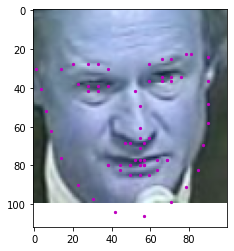

In [42]:
show_keypoints(xtrain[0], ytrain[0].reshape(68,2))

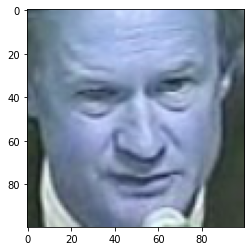

In [39]:
plt.imshow(xtrain[0])